In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataprep.eda import plot

In [188]:
data1 = pd.read_csv('mimic/50866data.csv')
# data1 = pd.read_csv('mimic/474data.csv')
admission = pd.read_csv("mimic/ADMISSIONS.csv")
admission['LOS'] = (pd.to_datetime(admission['DISCHTIME']) - pd.to_datetime(admission['ADMITTIME'])).dt.total_seconds()/86400


# LOS

In [202]:
data = data1.merge(admission[['HADM_ID', 'LOS']].reset_index(), on='HADM_ID')

y = data['LOS']
X = data.drop(['LOS', 'Unnamed: 0', 'HADM_ID', 'index'], axis=1)
feature_names = X.columns.values.tolist()

In [203]:
from sklearn import preprocessing
from keras.utils import to_categorical

sc = preprocessing.StandardScaler()
X = sc.fit_transform(X)

kb = preprocessing.KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')
y = kb.fit_transform(y.to_numpy().reshape(-1, 1))

y = to_categorical(y)

In [204]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.shape

(40692, 4)

In [205]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=4, random_state=0)
rfc.fit(X_train, y_train)
importance = rfc.feature_importances_

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


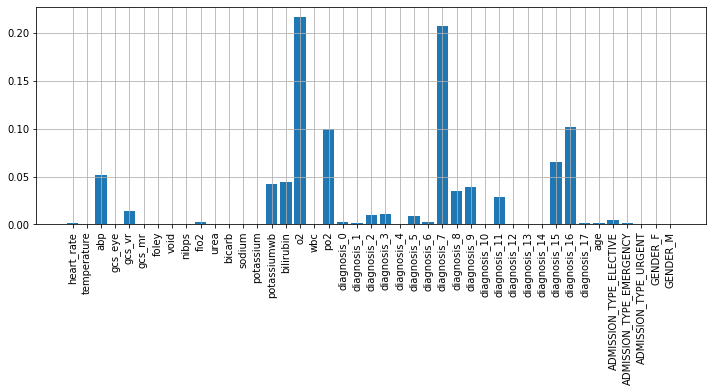

In [206]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(x=feature_names, height=importance)
ax.set_xticklabels(labels = feature_names, rotation=90)
ax.grid()

In [207]:
rf_score1 = rfc.score(X_test, y_test)
rf_score2 = rfc.score(X_train, y_train)
print(rf_score1)
print(rf_score2)

0.6817377629251032
0.6812149808316131


In [194]:
# Neural Network
model = Sequential()
model.add(Dense(64, input_dim=43, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
nn = model.fit(X_train, y_train, epochs=50, batch_size=128)
nn_score = model.evaluate(X_test, y_test, batch_size=128)
nn_score2 = model.evaluate(X_train, y_train, batch_size=128)
print(nn_score[1])
print(nn_score2[1])

Epoch 1/50
40692/40692 [==============================] - 4s 86us/step - loss: 0.7780 - accuracy: 0.6833
Epoch 2/50
40692/40692 [==============================] - 2s 51us/step - loss: 0.6670 - accuracy: 0.7197
Epoch 3/50
40692/40692 [==============================] - 2s 50us/step - loss: 0.6538 - accuracy: 0.7263
Epoch 4/50
40692/40692 [==============================] - 2s 52us/step - loss: 0.6469 - accuracy: 0.7297
Epoch 5/50
40692/40692 [==============================] - 2s 51us/step - loss: 0.6438 - accuracy: 0.7284
Epoch 6/50
40692/40692 [==============================] - 2s 58us/step - loss: 0.6417 - accuracy: 0.7319
Epoch 7/50
40692/40692 [==============================] - 2s 52us/step - loss: 0.6356 - accuracy: 0.7321
Epoch 8/50
40692/40692 [==============================] - 2s 52us/step - loss: 0.6347 - accuracy: 0.7337
Epoch 9/50
40692/40692 [==============================] - 2s 51us/step - loss: 0.6316 - accuracy: 0.7351
Epoch 10/50
40692/40692 [==============================

In [ ]:
# # Result:
# n_bins=6
# model = 
#     model = Sequential()

#     model.add(Dense(64, input_dim=44, kernel_initializer='normal', activation='relu'))

#     model.add(Dense(64, activation='relu'))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dense(6, activation='softmax'))

#     model.compile(loss='categorical_crossentropy',
#                   optimizer='adam', metrics=['accuracy'])
# estimator = KerasClassifier(build_fn=build_NN, epochs=200, batch_size=50, verbose=0)
# results = cross_val_score(estimator, X_train, y_train)
# Baseline: 50.58% (0.68%)


# bins=4
#     model = Sequential()

#     model.add(Dense(64, input_dim=44, kernel_initializer='normal', activation='relu'))

#     model.add(Dense(64, activation='relu'))

#     model.add(Dense(4, activation='softmax'))

#     model.compile(loss='categorical_crossentropy',
#                   optimizer='adam', metrics=['accuracy'])
# estimator = KerasClassifier(build_fn=build_NN, epochs=200, batch_size=50, verbose=0)
# Baseline: 67.37% (0.59%)

#     model.add(Dense(64, input_dim=44, kernel_initializer='normal', activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(4, activation='softmax'))

#     model.compile(loss='categorical_crossentropy',
#                   optimizer='adam', metrics=['accuracy'])
# estimator = KerasClassifier(build_fn=build_NN, epochs=50, batch_size=100, verbose=0)
# Baseline: 73.85% (0.50%)
# 
# 
# model = Sequential()
# model.add(Dense(64, input_dim=44, kernel_initializer='normal', activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(4, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# nn = model.fit(X_train, y_train, epochs=100, batch_size=100)
# nn_score = model.evaluate(X_test, y_test, batch_size=100)
# nn_score2 = model.evaluate(X_train, y_train, batch_size=100)
# [1.031969428062439, 0.6315789222717285]
# [0.26326988185301303, 0.9419525265693665]


# 50000data
# # model = Sequential()
# model.add(Dense(64, input_dim=44, kernel_initializer='normal', activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(4, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# nn = model.fit(X_train, y_train, epochs=50, batch_size=100)
# nn_score = model.evaluate(X_test, y_test, batch_size=100)
# nn_score2 = model.evaluate(X_train, y_train, batch_size=100)
# [73]
# [75]

# Mortality

In [220]:
data = data1.merge(admission[['HADM_ID', 'HOSPITAL_EXPIRE_FLAG']].reset_index(), on='HADM_ID')
y = data['HOSPITAL_EXPIRE_FLAG']
X = data.drop(['HOSPITAL_EXPIRE_FLAG', 'Unnamed: 0', 'HADM_ID', 'index'], axis=1)
feature_names=list(X)

In [221]:
sc = preprocessing.StandardScaler()
X = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [222]:
# LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

lr_score1 = lr.score(X_test, y_test)
lr_score2 = lr.score(X_train, y_train)
print(lr_score1)
print(lr_score2)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8892274425004915
0.8905681706477931


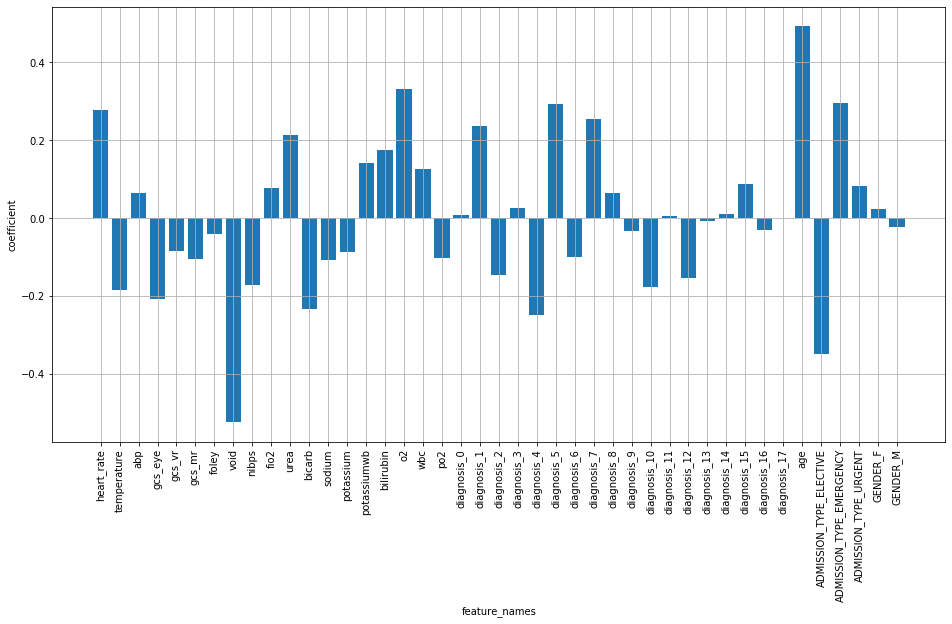

In [223]:
def explain_logistic_regression(lr, feature_names):
    plt.rcParams['figure.figsize'] = [16, 8]
    x = lr.coef_[0]
    plt.xticks(rotation=90)
    plt.xlabel('feature_names')
    plt.ylabel('coefficient')
    plt.grid()
    plt.bar(feature_names, x)
    plt.show()

explain_logistic_regression(lr, feature_names)

In [225]:
# Neural Network
model = Sequential()
model.add(Dense(64, input_dim=43, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn = model.fit(X_train, y_train, epochs=50, batch_size=128)
nn_score = model.evaluate(X_test, y_test, batch_size=128)
nn_score2 = model.evaluate(X_train, y_train, batch_size=128)
print(nn_score[1])
print(nn_score2[1])

Epoch 1/50
40692/40692 [==============================] - 4s 107us/step - loss: 0.3264 - accuracy: 0.8778
Epoch 2/50
40692/40692 [==============================] - 2s 61us/step - loss: 0.2779 - accuracy: 0.8880
Epoch 3/50
40692/40692 [==============================] - 2s 52us/step - loss: 0.2714 - accuracy: 0.8917
Epoch 4/50
40692/40692 [==============================] - 2s 52us/step - loss: 0.2660 - accuracy: 0.8923
Epoch 5/50
40692/40692 [==============================] - 2s 53us/step - loss: 0.2640 - accuracy: 0.8942
Epoch 6/50
40692/40692 [==============================] - 2s 52us/step - loss: 0.2610 - accuracy: 0.8952
Epoch 7/50
40692/40692 [==============================] - 2s 52us/step - loss: 0.2601 - accuracy: 0.8948
Epoch 8/50
40692/40692 [==============================] - 2s 52us/step - loss: 0.2581 - accuracy: 0.8947
Epoch 9/50
40692/40692 [==============================] - 2s 53us/step - loss: 0.2571 - accuracy: 0.8965
Epoch 10/50
40692/40692 [=============================